In [1]:
# %matplotlib notebook
import matplotlib.pyplot as plt
from scipy import linalg
import scipy.io as sio
import pprint as pp
import numpy as np
import seaborn as sns
import pandas as pd
import os
import re
import gc
# pre
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, Imputer
# Study
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
import matplotlib as mpl
import numpy as np
import itertools
from mpl_toolkits.mplot3d import Axes3D
from time import time
from scipy import stats

# helpers files
import infoStructure as ins
import helpers as hp
import display as dp
import clustering as cl
import importlib #importlib.reload(foo)

In [2]:
FEATHDir = '/sanssauvegarde/homes/v18porti/info/'
MDIR = FEATHDir

### Get saved DataFrame

In [3]:
df_ALL = pd.read_feather(FEATHDir + '200.feather')

In [4]:
df_ALL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50253405 entries, 0 to 50253404
Data columns (total 4 columns):
vectorRRKLD_ALL       float64
vectorFAmpKLD_ALL     float64
vectorUFAmpKLD_ALL    float64
vectorCorrKLD_ALL     float64
dtypes: float64(4)
memory usage: 1.5 GB


In [5]:
df_ALL.describe()

,vectorRRKLD_ALL,vectorFAmpKLD_ALL,vectorUFAmpKLD_ALL,vectorCorrKLD_ALL
count,5.025234e+07,5.025340e+07,5.025340e+07,4.933178e+07
mean,2.874678e+14,1.004443e+02,1.835926e+14,1.364375e+01
std,5.768096e+16,3.783401e+03,2.032571e+17,3.974665e+01
min,-1.196758e+01,0.000000e+00,-1.520206e+00,0.000000e+00
25%,8.378836e+00,3.710933e+00,1.080609e+01,4.991971e+00
50%,1.086595e+01,5.204808e+00,1.434429e+01,7.444819e+00
75%,1.581054e+01,7.724062e+00,2.119268e+01,1.172646e+01
max,3.421422e+19,8.780618e+05,2.250281e+20,1.712306e+03


In [6]:
df_ALL.corr()

,vectorRRKLD_ALL,vectorFAmpKLD_ALL,vectorUFAmpKLD_ALL,vectorCorrKLD_ALL
vectorRRKLD_ALL,1.000000,0.022457,-0.000004,0.001826
vectorFAmpKLD_ALL,0.022457,1.000000,0.002293,0.008833
vectorUFAmpKLD_ALL,-0.000004,0.002293,1.000000,0.043892
vectorCorrKLD_ALL,0.001826,0.008833,0.043892,1.000000


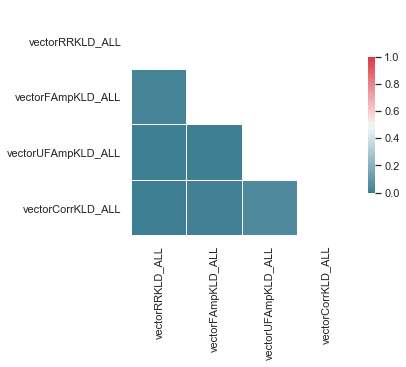

In [7]:
%matplotlib inline
dp.draw_correlation_matrix(df_ALL)

### Pre processing

In [8]:
df_final = df_ALL
del df_ALL

In [9]:
len(df_final) - df_final.count()

vectorRRKLD_ALL         1066
vectorFAmpKLD_ALL          0
vectorUFAmpKLD_ALL         0
vectorCorrKLD_ALL     921626
dtype: int64

In [10]:
num_attribs = list(df_final)

pipeline = Pipeline([
        ('selector', hp.DataFrameSelector(num_attribs)), # to handle pandas data frame
        ('imputer', Imputer(strategy="median")), # fill missing values with median
        ('std_scaler', StandardScaler())
    ])

full_pipeline = FeatureUnion(transformer_list=[
    ("main", pipeline),
    ])

data_prepared = full_pipeline.fit_transform(df_final)

In [11]:
df_normalized = hp.convertDictInDF(hp.putDataInDict(
        [data_prepared[:,0], data_prepared[:,1], data_prepared[:,2], data_prepared[:,3]],
        ['vectorRRKLD_N', 'vectorFAmpKLD_N', 'vectorUFAmpKLD_N', 'vectorCorrKLD_N']
    ))
df_normalized.describe()

,vectorRRKLD_N,vectorFAmpKLD_N,vectorUFAmpKLD_N,vectorCorrKLD_N
count,5.025340e+07,5.025340e+07,5.025340e+07,5.025340e+07
mean,-6.448265e-17,-1.939332e-18,1.651471e-17,-1.969895e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-4.983703e-03,-2.654869e-02,-9.032529e-04,-3.434961e-01
25%,-4.983703e-03,-2.556784e-02,-9.032529e-04,-2.156115e-01
50%,-4.983703e-03,-2.517299e-02,-9.032529e-04,-1.544899e-01
75%,-4.983703e-03,-2.450712e-02,-9.032529e-04,-4.910455e-02
max,5.931645e+02,2.320561e+02,1.107110e+03,4.312788e+01


In [12]:
del data_prepared, full_pipeline, pipeline

### PCA

>*[0.50219192 0.28210948 0.20605092 0.00964767]* : first 3 carries the most info with standarized data (95%)
>
>*[0.92169138 0.04827627 0.02278563 0.00724673]* : first 1 carries the most info without standarizing data
>
> This is how we know we should standarize since it permits the other 2 axes to participate

In [13]:
X = df_normalized
del df_normalized
gc.collect()

3159

In [14]:
pca = PCA(n_components=0.95)
pca.fit(X)  
print(pca.explained_variance_ratio_) 
print(pca.singular_values_)
print(pca.components_)

[0.25571667 0.25005    0.24987723 0.2443561 ]
[7169.55600176 7089.67243208 7087.222831   7008.48800293]
[[ 0.69886122  0.70290819  0.06966168  0.11251809]
 [-0.03959818  0.04108673  0.84401921 -0.53326864]
 [-0.12508917 -0.06205298  0.52686904  0.83839796]
 [ 0.70311996 -0.70737641  0.07202666  0.00728682]]


In [15]:
X = pca.transform(X)
del pca
gc.collect()
principalDf = pd.DataFrame(data=X, columns=['pc1', 'pc2', 'pc3', 'pc4'])

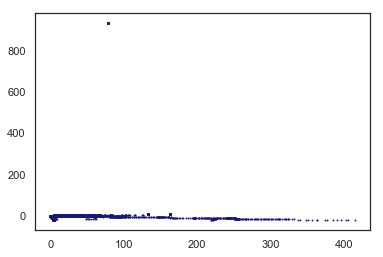

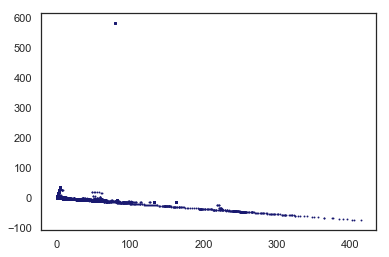

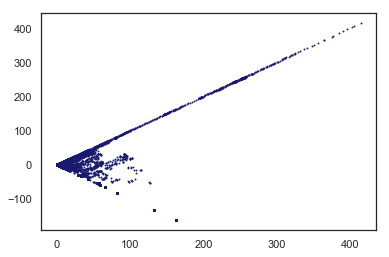

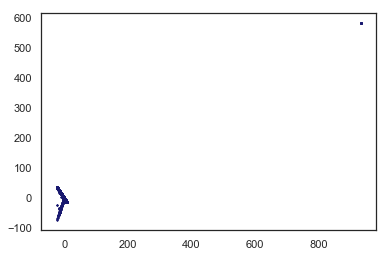

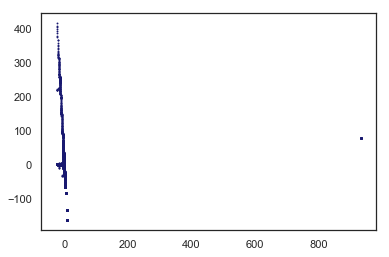

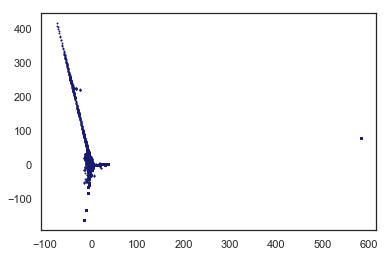

In [16]:
dp.printScatter(principalDf['pc1'], principalDf['pc2'])
dp.printScatter(principalDf['pc1'], principalDf['pc3'])
dp.printScatter(principalDf['pc1'], principalDf['pc4'])
dp.printScatter(principalDf['pc2'], principalDf['pc3'])
dp.printScatter(principalDf['pc2'], principalDf['pc4'])
dp.printScatter(principalDf['pc3'], principalDf['pc4'])

In [17]:
titles = principalDf.columns.tolist()
principalDf.describe()

,pc1,pc2,pc3,pc4
count,5.025340e+07,5.025340e+07,5.025340e+07,5.025340e+07
mean,1.603294e-16,4.166425e-17,-6.496451e-17,1.453792e-16
std,1.011369e+00,1.000100e+00,9.997544e-01,9.886478e-01
min,-6.085666e-02,-2.340929e+01,-7.432325e+01,-1.641557e+02
25%,-4.467433e-02,2.509904e-02,-1.800782e-01,1.235073e-02
50%,-3.753271e-02,8.078166e-02,-1.278089e-01,1.302255e-02
75%,-2.362285e-02,1.140386e-01,-4.029823e-02,1.385280e-02
max,4.148030e+02,9.346087e+02,5.830154e+02,4.167864e+02


## 1 Gaussian Mixture Model

https://scikit-learn.org/stable/unsupervised_learning.html


In [ ]:
n_components_range = range(1, 7)
best_gmm, bic, cv_types = cl.getBestGMMUsingBIC(X, n_components_range)

In [ ]:
bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange', 'gold', 'tomato'])
dp.plotBICScores(bic, cv_types, color_iter, n_components_range)

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 6))
dp.getPlotGMM(best_gmm, X, color_iter, 0, 1, ax[0], titles)
dp.getPlotGMM(best_gmm, X, color_iter, 1, 2, ax[1], titles)
dp.getPlotGMM(best_gmm, X, color_iter, 0, 2, ax[2], titles)
plt.show()
fig.clf()
plt.close()

In [ ]:
hp.getRepresentativeness(best_gmm, X, best_gmm.predict(X))

In [ ]:
del bic, best_gmm

## 2 K-Means

[4, 5, 6] components

In [ ]:
Y_, km = cl.getKmeanskClusters(4, X)
dp.printThreeKMaeans(X, Y_, titles)
print(hp.getRepresentativenessKM(km, X, Y_))
del km, Y_
plt.clf()
plt.close()

In [ ]:
Y_, km = cl.getKmeanskClusters(5, X)
dp.printThreeKMaeans(X, Y_, titles)
print(hp.getRepresentativenessKM(km, X, Y_))
del km, Y_
plt.clf()
plt.close()

In [ ]:
Y_, km = cl.getKmeanskClusters(6, X)
dp.printThreeKMaeans(X, Y_, titles)
print(hp.getRepresentativenessKM(km, X, Y_))
del km, Y_
plt.clf()
plt.close()

## 3 Mean Shift
https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

> Bandwidth is not very different with quantity of samples 50000 or 100000, so for ease of computation, we will use 50000.
> 
> Quantile, it increases  the value of the bandwith, 0.3, gets 1.76 with 7 components, 0.5, gets 2.26 with 4 components

In [ ]:
bandwidth = estimate_bandwidth(X, n_samples=50000, quantile=0.3)
bandwidth

In [ ]:
bandwidth2 = estimate_bandwidth(X, n_samples=50000, quantile=0.5)
bandwidth2

In [ ]:
bandwidth3 = estimate_bandwidth(X, n_samples=50000, quantile=0.7)
bandwidth3

In [ ]:
bandwidth4 = estimate_bandwidth(X, n_samples=50000, quantile=0.2)
bandwidth4

In [ ]:
ms, n_clusters_, cluster_centers, labels = cl.meanClustering(X, 4)
print(hp.getRepresentativenessKM(ms, X, ms.predict(X)))
dp.plotMSh(X, ms, n_clusters_, cluster_centers, labels)

In [ ]:
ms1, n_clusters_1, cluster_centers1, labels1 = cl.meanClustering(X, 5)
print(hp.getRepresentativenessKM(ms1, X, ms1.predict(X)))
dp.plotMSh(X, ms1, n_clusters_1, cluster_centers1, labels1)

## 4 Variational Bayesian Gaussian Mixture

Having 5 components, changig the n_init, it has a better distribution in "representativeness" with a value of 2 and max_iter = 200

In [ ]:
dpgmm1 = BayesianGaussianMixture(n_components=5,
                                max_iter=200, n_init=2,
                                covariance_type='full').fit(X)
#print(dpgmm1.means_)
#print(dpgmm1.covariances_)
Y_ = dpgmm1.predict(X)
print(hp.getRepresentativeness(dpgmm1, X, Y_))
fig, ax = plt.subplots(1, 3, figsize=(15, 6))
dp.plotGM(X, Y_, dpgmm1.means_, dpgmm1.covariances_, ax[0], 0, 1, color_iter)
dp.plotGM(X, Y_, dpgmm1.means_, dpgmm1.covariances_, ax[1], 1, 2, color_iter)
dp.plotGM(X, Y_, dpgmm1.means_, dpgmm1.covariances_, ax[2], 0, 2, color_iter)
plt.show()
fig.clf()
plt.close()

In [ ]:
dpgmm3 = BayesianGaussianMixture(n_components=4,
                                max_iter=200,n_init=2,
                                covariance_type='full').fit(X)
#print(dpgmm3.means_)
#print(dpgmm3.covariances_)
Y_ = dpgmm3.predict(X)
print(hp.getRepresentativeness(dpgmm3, X, Y_))
fig, ax = plt.subplots(1, 3, figsize=(15, 6))
dp.plotGM(X, Y_, dpgmm3.means_, dpgmm3.covariances_, ax[0], 0, 1, color_iter)
dp.plotGM(X, Y_, dpgmm3.means_, dpgmm3.covariances_, ax[1], 1, 2, color_iter)
dp.plotGM(X, Y_, dpgmm3.means_, dpgmm3.covariances_, ax[2], 0, 2, color_iter)
plt.show()
fig.clf()
plt.close()

In [ ]:
# modify n_jobs maybe???,,